# 🧪 MPTEDARLS Algorithm: Practical Workflow

## 📚 Table of Contents
- [Import Libraries](#import-libraries)
- [Read Data](#read-data)
- [Feature Selection](#feature-selection)
- [Outlier Injection](#outlier-injection)
- [Algorithm Overview](#algorithm-overview)
- [Evaluation](#evaluation)
- [WandB Tracking](#wandb-tracking)

---

## 📦 Import Libraries

In this section, we import all necessary libraries for data processing, algorithm implementation, evaluation metrics, and experiment tracking.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from mptedarls import MPTEDARLS
from sklearn.preprocessing import MinMaxScaler

## 📥 Read Data

The input datasets are loaded and basic inspections are performed to ensure data integrity.

In [ ]:
# Load merged data into a NumPy array
X_data = pd.read_csv("merged_df.csv").to_numpy()

## 🧪 Outlier Injection

Synthetic outliers are injected into the dataset to evaluate the robustness of the MSTEDARLS algorithm.  
The injection is performed based on predefined rules to simulate realistic anomaly patterns.

In [ ]:
# Copy of the original data
X_data_injected = X_data.copy()
true_outliers_mask = np.zeros_like(X_data_injected, dtype=bool)

# Total number of samples and features
n_samples, n_features = X_data.shape

# Total number of outliers: 10% of total samples
total_outliers = int(n_samples * 0.10)

# Random number generator with fixed seed
rng = np.random.default_rng(seed=42)

# Distribute outliers equally among the features
outliers_per_feature = total_outliers // n_features

for i in range(n_features):
    mean = np.mean(X_data[:, i])
    std = np.std(X_data[:, i])
    outlier_value = mean + 10 * std  # extreme value

    # Select random samples (without replacement)
    idx = rng.choice(n_samples, size=outliers_per_feature, replace=False)
    X_data_injected[idx, i] = outlier_value
    true_outliers_mask[idx, i] = True

In [ ]:
# print the min and max values of the injected data
print("Min and max values of the injected data:")
print("Min:", np.min(X_data_injected))
print("Max:", np.max(X_data_injected))

# Normalize the data
scaler = MinMaxScaler()
X_data_injected = scaler.fit_transform(X_data_injected)
X_data = scaler.transform(X_data)

# print the min and max values of the injected data after normalization
print("Min and max values of the injected data after normalization:")
print("Min:", scaler.data_min_)
print("Max:", scaler.data_max_)

Min and max values of the injected data:
Min: -36.0
Max: 6267.896294467528
Min and max values of the injected data after normalization:
Min: [  0.   0.   0.   0. -36.]
Max: [ 216.83813265 6267.89629447  265.92001187  280.9220282   127.99778524]


## ⚙️ Algorithm Overview

The MPTEDARLS (Multivariate Parallel TEDA with RLS) algorithm extends the TEDA-RLS framework to process multivariate signals simultaneously.  
Instead of analyzing each feature independently, MPTEDARLS evaluates the entire multivariate sample at once, enabling a more cohesive detection of anomalous patterns across features.

The method combines two key components:

- **Typicality and Eccentricity Data Analytics (TEDA):**  
  Computes the typicality and eccentricity of each incoming multivariate sample, allowing for the detection of deviations from expected behavior.

- **Recursive Least Squares (RLS) Filter:**  
  Updates the model parameters incrementally and predicts the expected sample, supporting correction mechanisms when outliers are detected.

### 🔍 Key Characteristics:
- **Multivariate Evaluation:** All features are jointly evaluated using a single TEDA instance.
- **Anomaly Detection:** The entire multivariate sample is classified as normal or anomalous based on typicality and eccentricity measures.
- **Correction Mechanism:** When an outlier is detected, the RLS filter predicts the corrected sample.
- **Incremental Operation:** Statistics are updated online without needing to store past samples.
- **Low Computational Cost:** Suitable for real-time applications on embedded systems.

### 📥 Input:
- Multivariate sample $\mathbf{x}_k \in \mathbb{R}^n$ at time $k$.

### 📤 Output:
- Corrected sample $\hat{\mathbf{x}}_k$.
- Predicted sample $\tilde{\mathbf{x}}_k$ (RLS output).
- Outlier detection flag.

---

In [ ]:
# ======================================
# 3. Run Model
# ======================================

def run_model(normalize=False):
    """
    If normalize=True, applies MinMaxScaler before running the model.
    Then, reverts the correction back to the original scale for proper visualization.
    """
    if normalize:
        # Manual normalization parameters
        min_vals = np.array([  0. ,  0. ,  0. , 0. , -36.])
        max_vals = np.array([ 216.83813265, 6267.89629447,  265.92001187,  280.9220282,   127.99778524])
        scale = 1 / (max_vals - min_vals)

        X_norm = (X_data_injected - min_vals) * scale

        model = MPTEDARLS(
            threshold=6.0,
            ecc_div=4.0,
            rls_mu=0.9999,
            rls_n=X_data.shape[1],
            correct_outlier=True,
            use_per_dim_teda=False,
            window_outlier_limit=15,
            max_dw=5,
        )

        corrected_data_scaled = []
        predicted_data_scaled = []
        outliers_mask = []

        for x in X_norm:
            outlier_flag, y_pred, x_corr = model.run(x)
            corrected_data_scaled.append(x_corr)
            predicted_data_scaled.append(y_pred)

            # Align with C++ global outlier detection
            outliers_mask.append(np.full_like(x, outlier_flag, dtype=bool))

        corrected_data_scaled = np.array(corrected_data_scaled)
        predicted_data_scaled = np.array(predicted_data_scaled)
        outliers_mask = np.array(outliers_mask)

        # Reverse normalization back to original scale
        corrected_data = corrected_data_scaled / scale + min_vals
        predicted_data = predicted_data_scaled / scale + min_vals
        outliers_mask = outliers_mask.astype(bool)

        # Save debug log
        debug_df = pd.DataFrame(model.debug_log)
        debug_df.to_csv("debug_log_python.csv", index=False, float_format="%.16f")

        return corrected_data, predicted_data, outliers_mask
    else:
        # Without normalization
        model = MPTEDARLS(
            threshold=6.0,
            ecc_div=4.0,
            rls_mu=0.9999,
            rls_n=X_data.shape[1],
            correct_outlier=True,
            use_per_dim_teda=False,
            window_outlier_limit=15,
            max_dw=5,
        )

        corrected_data = []
        predicted_data = []
        outliers_mask = []

        for x in X_data_injected:
            outlier_flag, y_pred, x_corr = model.run(x)
            corrected_data.append(x_corr)
            predicted_data.append(y_pred)
            outliers_mask.append(outlier_flag)

        return np.array(corrected_data), np.array(predicted_data), np.array(outliers_mask)


# Run one of the two options below:
# 1) Without normalization
# corrected_std, pred_std, flags_std = run_model(normalize=False)

# 2) With normalization
corrected_std, pred_std, flags_std = run_model(normalize=True)

## 📊 Evaluation

Performance metrics are computed to assess the algorithm’s capability in detecting and correcting outliers, including:

- Precision
- Recall
- F1-Score

Visual comparisons between original, anomalous, and corrected series are also provided.

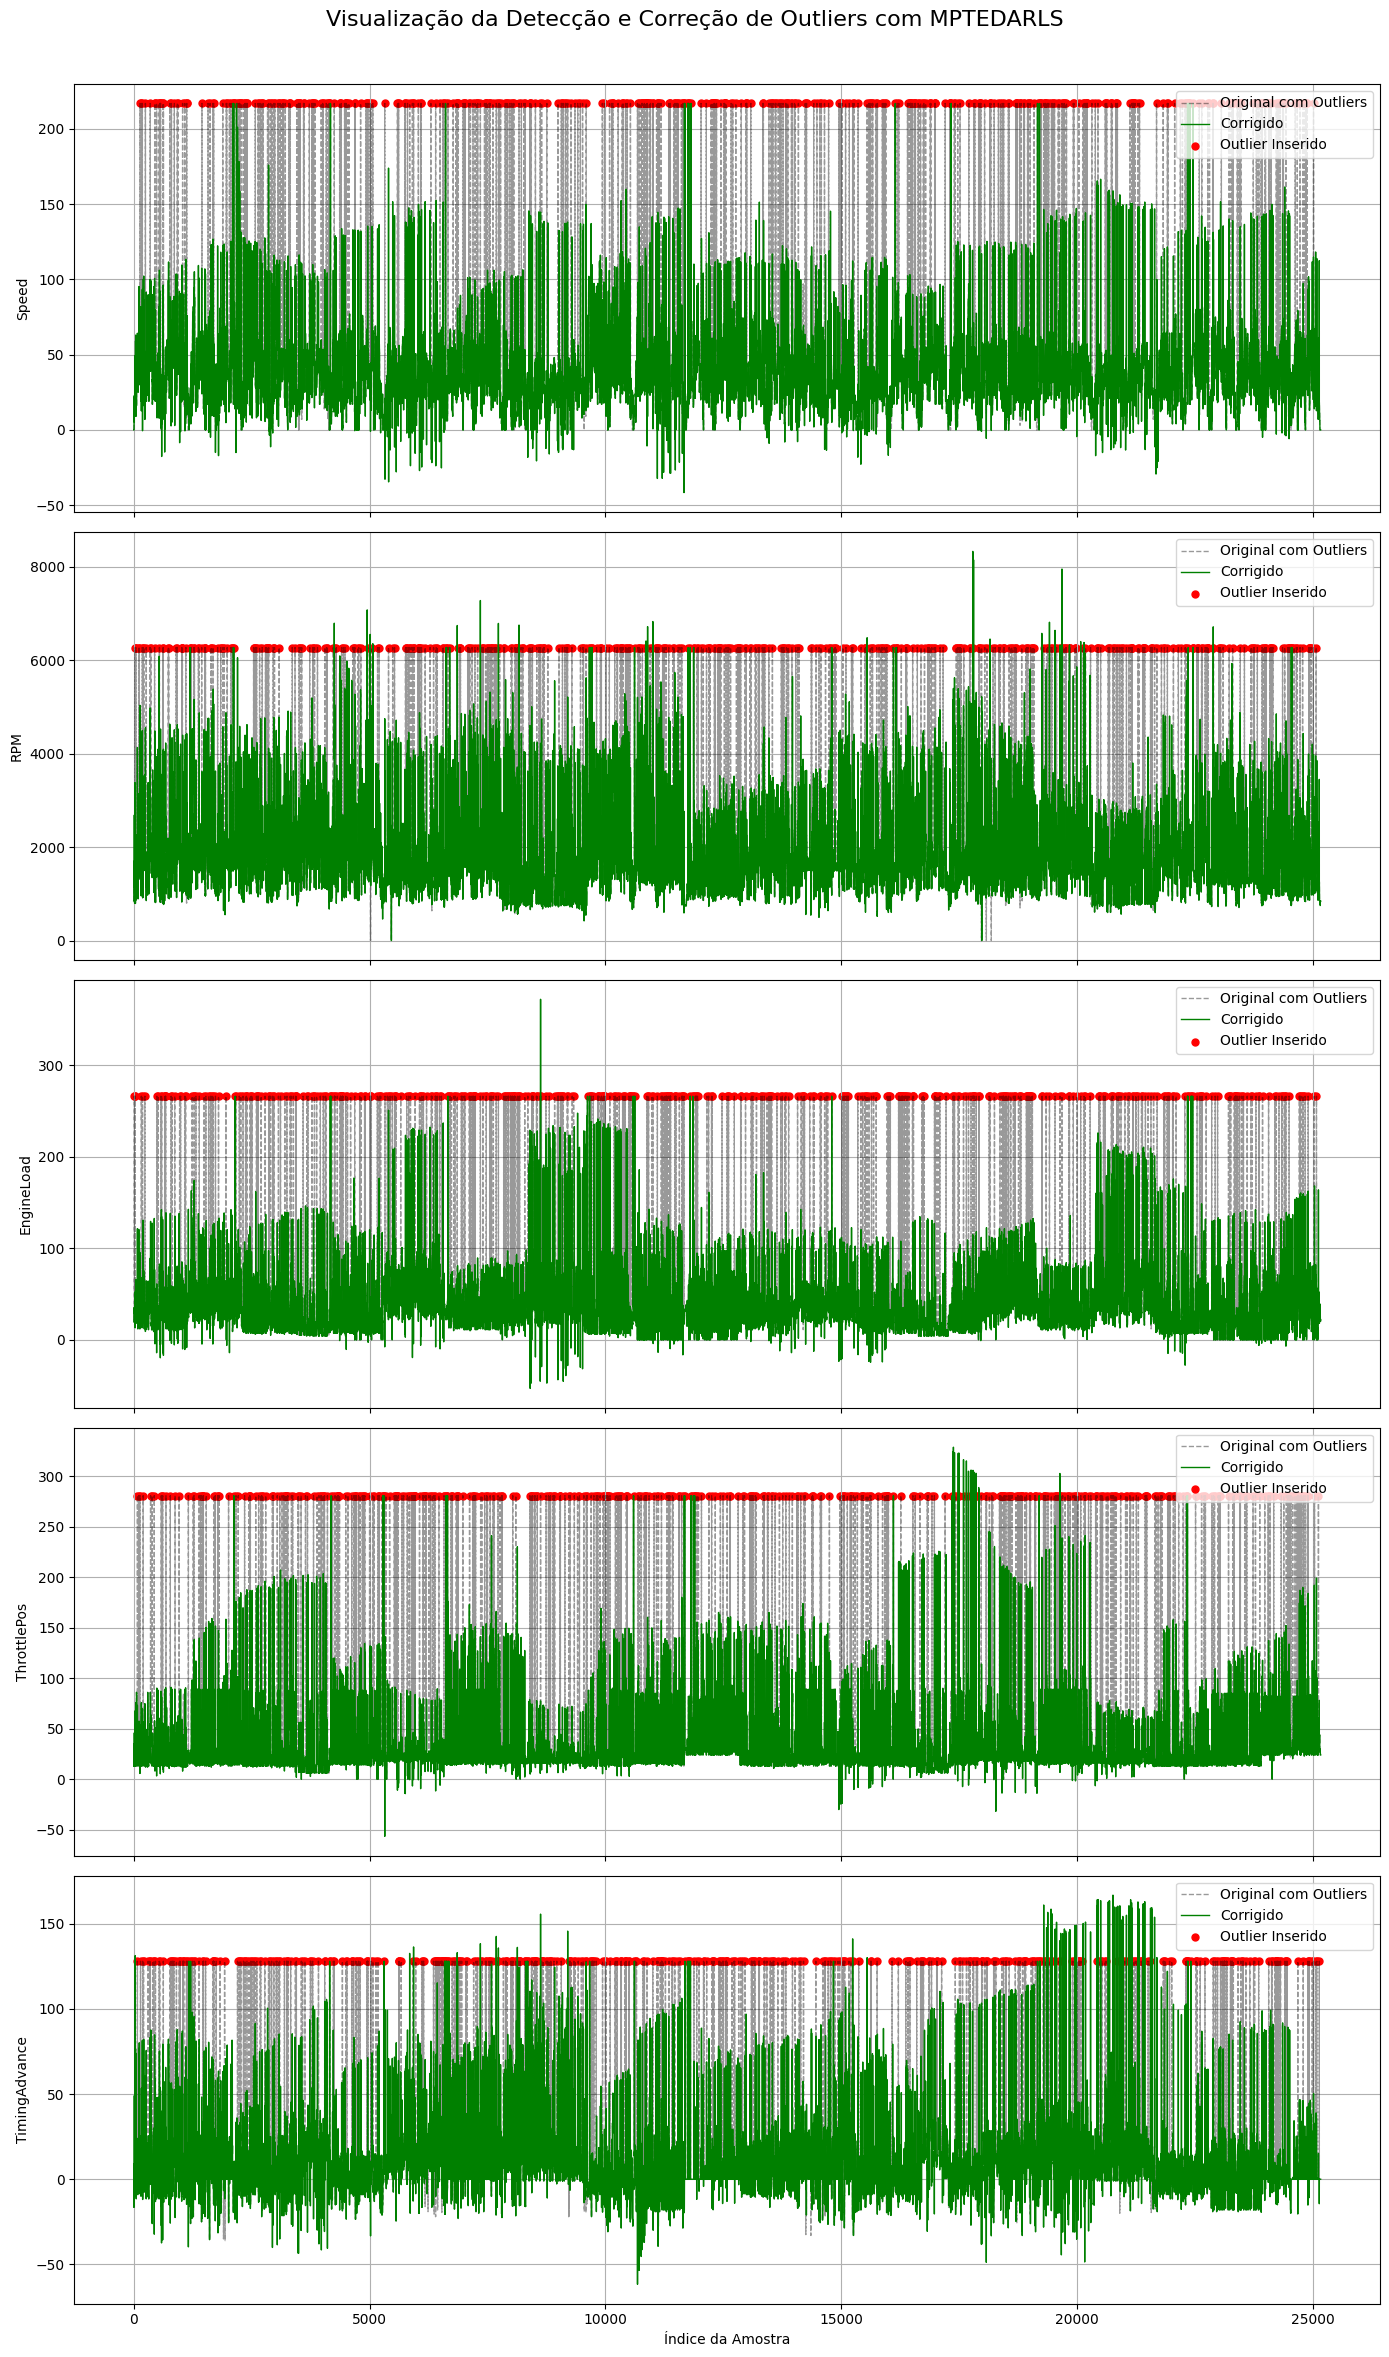

In [ ]:
columns = ['Speed', 'RPM', 'EngineLoad', 'ThrottlePos', 'TimingAdvance']

# ======================================
# 4. Final Plotting - Publication Style
# ======================================

fig, axes = plt.subplots(nrows=5, ncols=1, figsize=(14, 24), sharex=True)
for i, ax in enumerate(axes):
    ax.plot(X_data_injected[:, i], 'k--', linewidth=1, alpha=0.4, label='Original with Outliers')
    # ax.plot(pred_std[:, i], 'orange', linewidth=1, alpha=0.6, label='Predicted (RLS)')
    ax.plot(corrected_std[:, i], 'g-', linewidth=1, label='Corrected')

    outlier_indices = np.where(true_outliers_mask[:, i])[0]
    ax.scatter(outlier_indices, X_data_injected[outlier_indices, i], c='red', s=25, label='Injected Outlier')
    ax.set_ylabel(columns[i])
    ax.legend(loc='upper right')
    ax.grid(True)

axes[-1].set_xlabel("Sample Index")
fig.suptitle("Visualization of Outlier Detection and Correction using MPTEDARLS", fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.97])
plt.show()

In [5]:
# Salve os dados corrigidos com python
df_corrected = pd.DataFrame(corrected_std, columns=columns)
df_corrected.to_csv("corrigido_python.csv", index=False, float_format='%.16f')

In [ ]:
from sklearn.metrics import confusion_matrix
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

# ==========================
# 7. Final Evaluation (Aligned with C++)
# ==========================

# Use the binary mask generated directly during the execution loop
detected_outliers_mask = flags_std.astype(bool)

# Initialize metrics dictionary
metrics = {
    "Feature": [],
    "Accuracy (%)": [],
    "Precision (%)": [],
    "Recall (%)": [],
    "F1-score (%)": [],
    "False Positives (%)": [],
    "False Negatives (%)": [],
}

# Metrics calculation per feature
for i, var in enumerate(columns):
    y_true = true_outliers_mask[:, i].astype(int)
    y_pred = detected_outliers_mask[:, i].astype(int)

    try:
        tn, fp, fn, tp = confusion_matrix(y_true, y_pred, labels=[0, 1]).ravel()
    except:
        tn = np.sum((y_true == 0) & (y_pred == 0))
        fp = np.sum((y_true == 0) & (y_pred == 1))
        fn = np.sum((y_true == 1) & (y_pred == 0))
        tp = np.sum((y_true == 1) & (y_pred == 1))

    acc = (tp + tn) / (tp + tn + fp + fn)
    prec = tp / (tp + fp) if (tp + fp) > 0 else 0.0
    rec = tp / (tp + fn) if (tp + fn) > 0 else 0.0
    f1 = 2 * prec * rec / (prec + rec) if (prec + rec) > 0 else 0.0
    fpr = fp / (fp + tn) if (fp + tn) > 0 else 0.0
    fnr = fn / (fn + tp) if (fn + tp) > 0 else 0.0

    metrics["Feature"].append(var)
    metrics["Accuracy (%)"].append(acc * 100)
    metrics["Precision (%)"].append(prec * 100)
    metrics["Recall (%)"].append(rec * 100)
    metrics["F1-score (%)"].append(f1 * 100)
    metrics["False Positives (%)"].append(fpr * 100)
    metrics["False Negatives (%)"].append(fnr * 100)

# Create final metrics DataFrame
df_metrics = pd.DataFrame(metrics).round(2)
display(df_metrics)

,Variável,Acurácia (%),Precisão (%),Revocação (%),F1-score (%),Falsos Positivos (%),Falsos Negativos (%)
0,Speed,89.21,15.15,95.63,26.16,10.92,4.37
1,RPM,89.19,15.09,95.23,26.05,10.93,4.77
2,EngineLoad,89.25,15.31,96.62,26.43,10.90,3.38
3,ThrottlePos,89.23,15.25,96.22,26.33,10.91,3.78
4,TimingAdvance,89.17,15.00,94.63,25.89,10.94,5.37


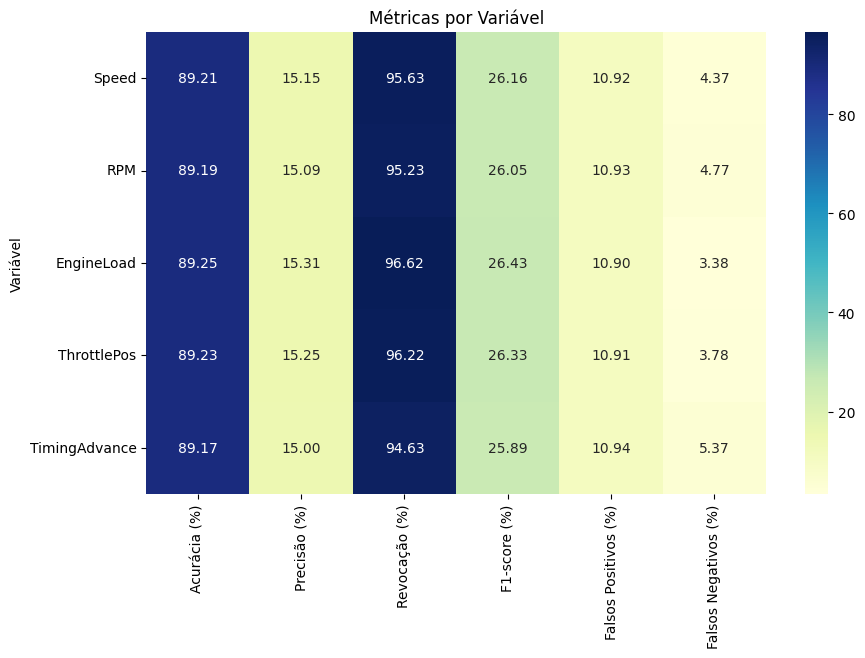

In [ ]:
plt.figure(figsize=(10, 6))
sns.heatmap(df_metrics.set_index("Variable").dropna(), annot=True, cmap="YlGnBu", fmt=".2f")
plt.title("Confusion Matrix Metrics")
plt.show()

In [ ]:
# ======================================
# 5. Save data for execution in C++
# ======================================

# Save the data with injected outliers
df_injected = pd.DataFrame(X_data_injected, columns=columns)
df_injected.to_csv("data_with_outliers.csv", index=False)

# Save the ground truth outlier mask (0 or 1)
df_mask = pd.DataFrame(true_outliers_mask.astype(int), columns=columns)
df_mask.to_csv("ground_truth_mask.csv", index=False)

# (Optional) Save the original data without injected outliers
df_original = pd.DataFrame(X_data, columns=columns)
df_original.to_csv("X_data_original.csv", index=False)

## 📈 WandB Tracking

Experiment parameters, training metrics, and evaluation results are logged to the [Weights & Biases](https://wandb.ai/) platform for systematic tracking and reproducibility.

Key benefits of using WandB include:
- Visualization of metric evolution.
- Comparison between different hyperparameter settings.
- Organized experiment management.

In [9]:
import wandb

wandb.login()

wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: morsinaldo to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


True

In [ ]:
def train_with_config():
    with wandb.init() as run:
        config = wandb.config

        min_vals = np.array([  0. ,  0. ,  0. , 0. , -36.])
        max_vals = np.array([ 216.83813265, 6267.89629447,  265.92001187,  280.9220282,   127.99778524])
        scale = 1 / (max_vals - min_vals)

        X_norm = (X_data_injected - min_vals) * scale

        model = MPTEDARLS(
            threshold=config.threshold,
            ecc_div=config.ecc_div,
            rls_mu=config.rls_mu,
            rls_n=X_data.shape[1],
            correct_outlier=config.correct_outlier,
            use_per_dim_teda=config.use_per_dim_teda,
            window_outlier_limit=config.window_outlier_limit,
            max_dw=config.max_dw,
        )

        corrected_data_scaled = []
        predicted_data_scaled = []
        outliers_mask = []
        
        for x in X_norm:
            outlier_flag, y_pred, x_corr = model.run(x)
            corrected_data_scaled.append(x_corr)
            predicted_data_scaled.append(y_pred)

            # Align with C++ global outlier detection
            outliers_mask.append(np.full_like(x, outlier_flag, dtype=bool))

        corrected_data_scaled = np.array(corrected_data_scaled)
        predicted_data_scaled = np.array(predicted_data_scaled)
        outliers_mask = np.array(outliers_mask)

        # Reverse normalization back to the original scale
        corrected_data = corrected_data_scaled / scale + min_vals
        predicted_data = predicted_data_scaled / scale + min_vals
        outliers_mask = outliers_mask.astype(bool)

        # Use the binary mask generated directly during the execution loop
        detected_outliers_mask = outliers_mask.astype(bool)

        # Initialize metrics dictionary
        metrics = {
            "Feature": [],
            "Accuracy (%)": [],
            "Precision (%)": [],
            "Recall (%)": [],
            "F1-score (%)": [],
            "False Positives (%)": [],
            "False Negatives (%)": [],
        }

        # Metrics calculation per feature
        for i, var in enumerate(columns):
            y_true = true_outliers_mask[:, i].astype(int)
            y_pred = detected_outliers_mask[:, i].astype(int)

            try:
                tn, fp, fn, tp = confusion_matrix(y_true, y_pred, labels=[0, 1]).ravel()
            except:
                tn = np.sum((y_true == 0) & (y_pred == 0))
                fp = np.sum((y_true == 0) & (y_pred == 1))
                fn = np.sum((y_true == 1) & (y_pred == 0))
                tp = np.sum((y_true == 1) & (y_pred == 1))

            acc = (tp + tn) / (tp + tn + fp + fn)
            prec = tp / (tp + fp) if (tp + fp) > 0 else 0.0
            rec = tp / (tp + fn) if (tp + fn) > 0 else 0.0
            f1 = 2 * prec * rec / (prec + rec) if (prec + rec) > 0 else 0.0
            fpr = fp / (fp + tn) if (fp + tn) > 0 else 0.0
            fnr = fn / (fn + tp) if (fn + tp) > 0 else 0.0

            metrics["Feature"].append(var)
            metrics["Accuracy (%)"].append(acc * 100)
            metrics["Precision (%)"].append(prec * 100)
            metrics["Recall (%)"].append(rec * 100)
            metrics["F1-score (%)"].append(f1 * 100)
            metrics["False Positives (%)"].append(fpr * 100)
            metrics["False Negatives (%)"].append(fnr * 100)

        wandb.log({
            "Accuracy (%)": acc * 100,
            "Precision (%)": prec * 100,
            "Recall (%)": rec * 100,
            "F1-score (%)": f1 * 100,
            "False Positives (%)": fpr * 100,
            "False Negatives (%)": fnr * 100,
        })

In [ ]:
sweep_config = {
    "method": "bayes",
    "metric": {"name": "Accuracy (%)", "goal": "maximize"},
    "parameters": {
        "threshold": {"min": 2.0, "max": 10.0},
        "ecc_div": {"values": [2.0, 4.0, 6.0]},
        "rls_mu": {"min": 0.9, "max": 0.9999},
        "correct_outlier": {"values": [True]},
        "use_per_dim_teda": {"values": [False]}, 
        "window_outlier_limit": {"values": [5, 10, 15, 20, 25, 30, 40, 50, 60, 70, 80, 90, 100]},
        "max_dw": {"values": [3, 5, 7, 10, 15, 20]},
    }
}

# Create the sweep
sweep_id = wandb.sweep(sweep_config, project="MPTEDARLS-sweep")

# Run the agent in Python
wandb.agent(sweep_id, function=train_with_config, count=10)  # count defines the number of runs

Create sweep with ID: iv1oaagz
Sweep URL: https://wandb.ai/morsinaldo/MPTEDARLS-sweep/sweeps/iv1oaagz


wandb: Agent Starting Run: iu05r7mx with config:
wandb: 	correct_outlier: True
wandb: 	ecc_div: 2
wandb: 	max_dw: 7
wandb: 	rls_mu: 0.9903366229610244
wandb: 	threshold: 6.151706179931832
wandb: 	use_per_dim_teda: False
wandb: 	window_outlier_limit: 20


Acurácia (%),▁
F1-score (%),▁
Falsos Negativos (%),▁
Falsos Positivos (%),▁
Precisão (%),▁
Revocação (%),▁
Acurácia (%),83.7493
F1-score (%),18.91731
Falsos Negativos (%),5.16899
Falsos Positivos (%),16.47674
Precisão (%),10.50661


wandb: Agent Starting Run: jitb7f47 with config:
wandb: 	correct_outlier: True
wandb: 	ecc_div: 6
wandb: 	max_dw: 10
wandb: 	rls_mu: 0.9249354342302796
wandb: 	threshold: 5.592291098993105
wandb: 	use_per_dim_teda: False
wandb: 	window_outlier_limit: 5


Acurácia (%),▁
F1-score (%),▁
Falsos Negativos (%),▁
Falsos Positivos (%),▁
Precisão (%),▁
Revocação (%),▁
Acurácia (%),92.78277
F1-score (%),33.67421
Falsos Negativos (%),8.3499
Falsos Positivos (%),7.19413
Precisão (%),20.6264


wandb: Agent Starting Run: jhkdn1k6 with config:
wandb: 	correct_outlier: True
wandb: 	ecc_div: 6
wandb: 	max_dw: 5
wandb: 	rls_mu: 0.9674000652335962
wandb: 	threshold: 6.9646591495256995
wandb: 	use_per_dim_teda: False
wandb: 	window_outlier_limit: 70


Acurácia (%),▁
F1-score (%),▁
Falsos Negativos (%),▁
Falsos Positivos (%),▁
Precisão (%),▁
Revocação (%),▁
Acurácia (%),66.27057
F1-score (%),10.23797
Falsos Negativos (%),3.77734
Falsos Positivos (%),34.3404
Precisão (%),5.40661


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: x1i3yi02 with config:
wandb: 	correct_outlier: True
wandb: 	ecc_div: 4
wandb: 	max_dw: 20
wandb: 	rls_mu: 0.9267915409529416
wandb: 	threshold: 8.879042994691673
wandb: 	use_per_dim_teda: False
wandb: 	window_outlier_limit: 80


Acurácia (%),▁
F1-score (%),▁
Falsos Negativos (%),▁
Falsos Positivos (%),▁
Precisão (%),▁
Revocação (%),▁
Acurácia (%),65.36841
F1-score (%),10.12789
Falsos Negativos (%),2.38569
Falsos Positivos (%),35.28935
Precisão (%),5.34102


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: o9kdbigs with config:
wandb: 	correct_outlier: True
wandb: 	ecc_div: 6
wandb: 	max_dw: 10
wandb: 	rls_mu: 0.9225226882961588
wandb: 	threshold: 2.384238072257662
wandb: 	use_per_dim_teda: False
wandb: 	window_outlier_limit: 5


Acurácia (%),▁
F1-score (%),▁
Falsos Negativos (%),▁
Falsos Positivos (%),▁
Precisão (%),▁
Revocação (%),▁
Acurácia (%),90.66847
F1-score (%),28.32723
Falsos Negativos (%),7.75348
Falsos Positivos (%),9.36372
Precisão (%),16.73278


wandb: Agent Starting Run: 9jmnfxet with config:
wandb: 	correct_outlier: True
wandb: 	ecc_div: 4
wandb: 	max_dw: 7
wandb: 	rls_mu: 0.9392960154216098
wandb: 	threshold: 4.763329886338875
wandb: 	use_per_dim_teda: False
wandb: 	window_outlier_limit: 10


Acurácia (%),▁
F1-score (%),▁
Falsos Negativos (%),▁
Falsos Positivos (%),▁
Precisão (%),▁
Revocação (%),▁
Acurácia (%),89.95708
F1-score (%),27.65531
Falsos Negativos (%),3.97614
Falsos Positivos (%),10.16667
Precisão (%),16.15385


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: bs036pl8 with config:
wandb: 	correct_outlier: True
wandb: 	ecc_div: 6
wandb: 	max_dw: 7
wandb: 	rls_mu: 0.9133897444856248
wandb: 	threshold: 3.6007751516021935
wandb: 	use_per_dim_teda: False
wandb: 	window_outlier_limit: 5


Acurácia (%),▁
F1-score (%),▁
Falsos Negativos (%),▁
Falsos Positivos (%),▁
Precisão (%),▁
Revocação (%),▁
Acurácia (%),91.83292
F1-score (%),31.52283
Falsos Negativos (%),5.96421
Falsos Positivos (%),8.21201
Precisão (%),18.93515


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: oedknhe0 with config:
wandb: 	correct_outlier: True
wandb: 	ecc_div: 6
wandb: 	max_dw: 15
wandb: 	rls_mu: 0.9118214670882362
wandb: 	threshold: 2.224563445548566
wandb: 	use_per_dim_teda: False
wandb: 	window_outlier_limit: 5


Acurácia (%),▁
F1-score (%),▁
Falsos Negativos (%),▁
Falsos Positivos (%),▁
Precisão (%),▁
Revocação (%),▁
Acurácia (%),90.46578
F1-score (%),28.10908
Falsos Negativos (%),6.75944
Falsos Positivos (%),9.59082
Precisão (%),16.54905


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 0uh1wyyn with config:
wandb: 	correct_outlier: True
wandb: 	ecc_div: 6
wandb: 	max_dw: 7
wandb: 	rls_mu: 0.909880825462622
wandb: 	threshold: 5.349841128794546
wandb: 	use_per_dim_teda: False
wandb: 	window_outlier_limit: 5


Acurácia (%),▁
F1-score (%),▁
Falsos Negativos (%),▁
Falsos Positivos (%),▁
Precisão (%),▁
Revocação (%),▁
Acurácia (%),92.65957
F1-score (%),33.72802
Falsos Negativos (%),6.56064
Falsos Positivos (%),7.35634
Precisão (%),20.57793


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: uxse5lcg with config:
wandb: 	correct_outlier: True
wandb: 	ecc_div: 4
wandb: 	max_dw: 15
wandb: 	rls_mu: 0.9033122769649036
wandb: 	threshold: 2.1947538538366915
wandb: 	use_per_dim_teda: False
wandb: 	window_outlier_limit: 5


Acurácia (%),▁
F1-score (%),▁
Falsos Negativos (%),▁
Falsos Positivos (%),▁
Precisão (%),▁
Revocação (%),▁
Acurácia (%),89.24966
F1-score (%),25.95127
Falsos Negativos (%),5.76541
Falsos Positivos (%),10.85202
Precisão (%),15.04762


In [12]:
wandb.finish()